<a href="https://colab.research.google.com/github/irwardhana/DEVSAT_ENV/blob/main/ANALISIS_DATA_DAN_PEMODELAN_(DATA_ANALYSIS_%26_MODELING).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== ANALISIS DATA ===

Ringkasan statistik fitur utama:
                           timestamp  cpu_usage (%)  memory_usage (%)  \
count                          34752   34752.000000      34752.000000   
mean   2025-04-01 11:45:00.000000256      51.810505         45.655069   
min              2025-01-01 00:00:00       6.821741         19.999005   
25%              2025-02-15 05:52:30      42.785237         40.387416   
50%              2025-04-01 11:45:00      51.133016         45.061163   
75%              2025-05-16 17:37:30      59.487484         50.584075   
max              2025-06-30 23:30:00     100.000000         73.021099   
std                              NaN      13.202951          7.390752   

       latency (ms)  packet_loss (%)  bandwidth_utilization (%)  \
count  34752.000000     34752.000000               34752.000000   
mean      29.786901         0.994992                  50.747071   
min        1.000000         0.000000                   3.867479   
25%       18.14171

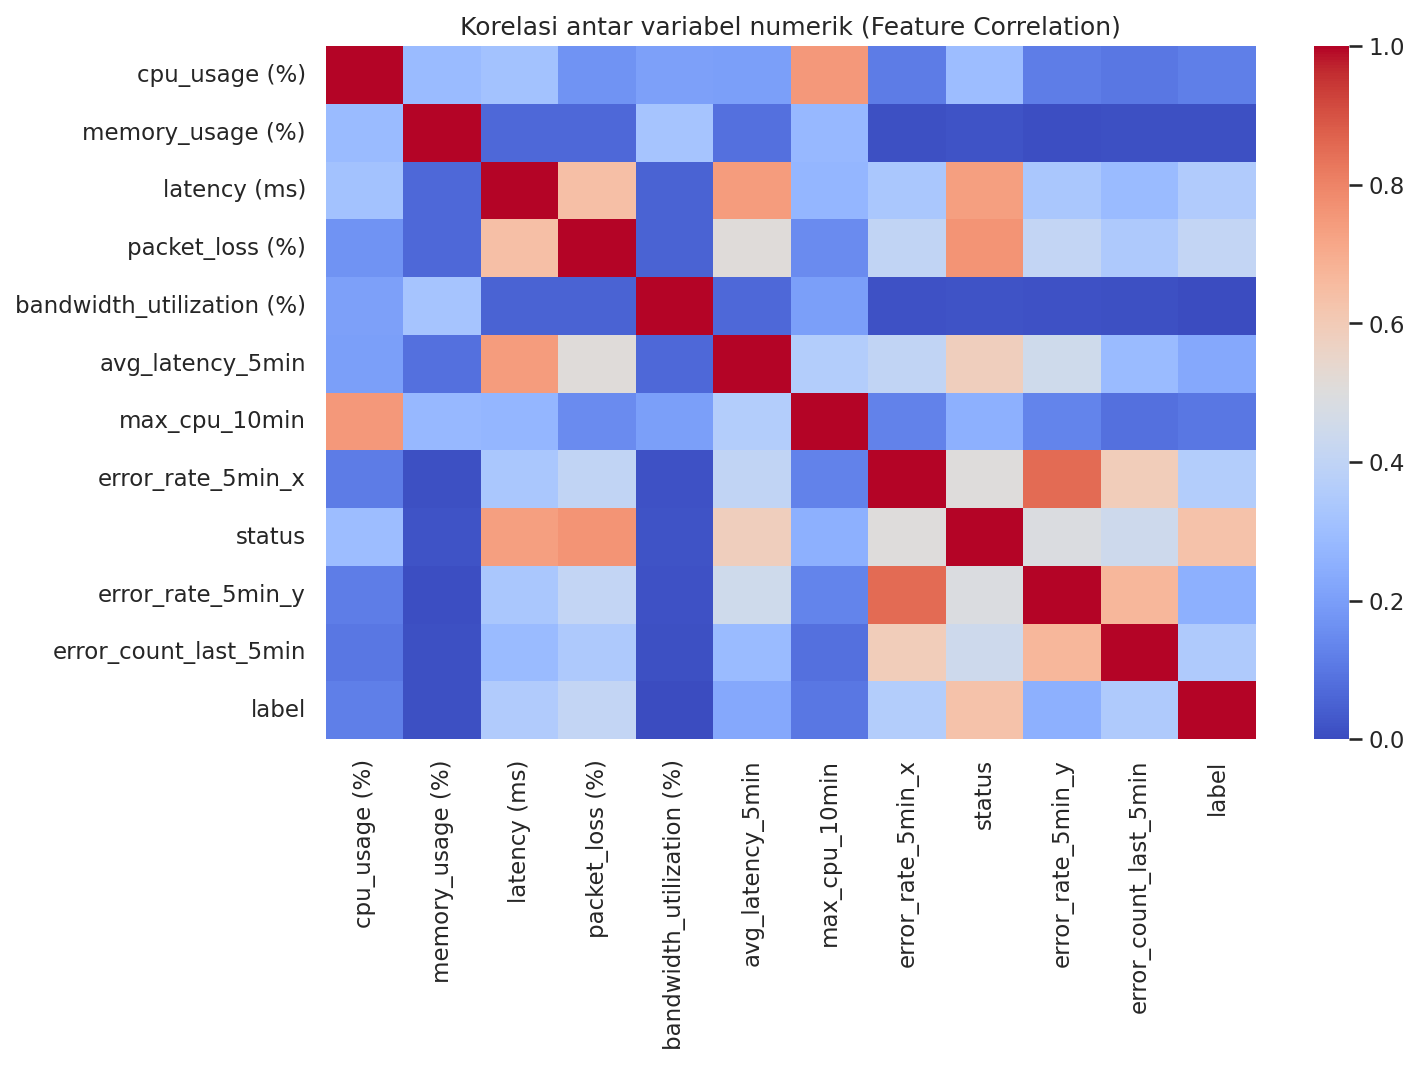

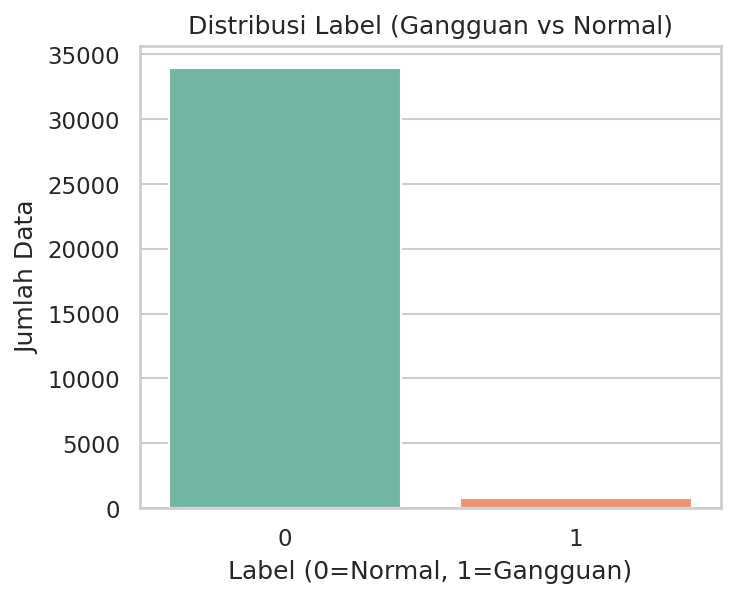


=== EVALUASI MODEL RANDOM FOREST ===

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6792
           1       0.74      0.94      0.83       159

    accuracy                           0.99      6951
   macro avg       0.87      0.96      0.91      6951
weighted avg       0.99      0.99      0.99      6951


Confusion Matrix:
[[6741   51]
 [  10  149]]

ROC-AUC: 0.9987


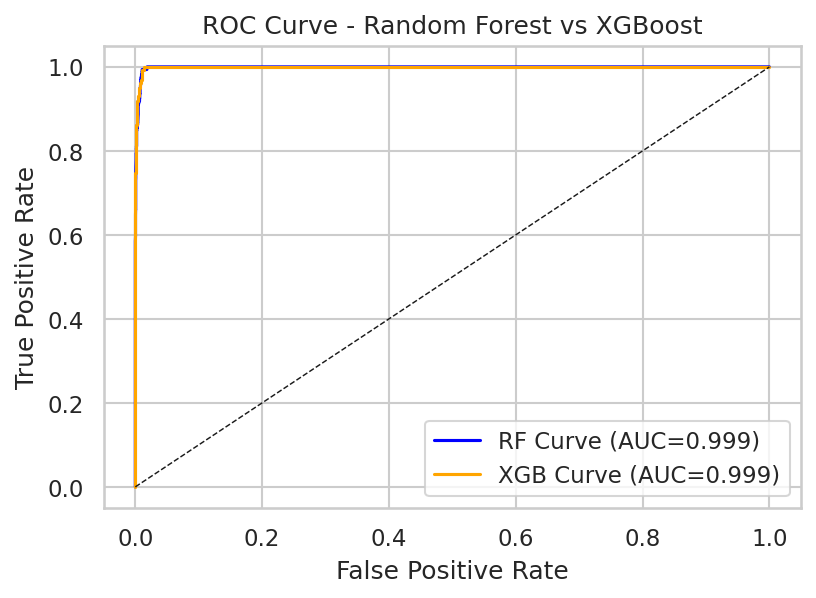

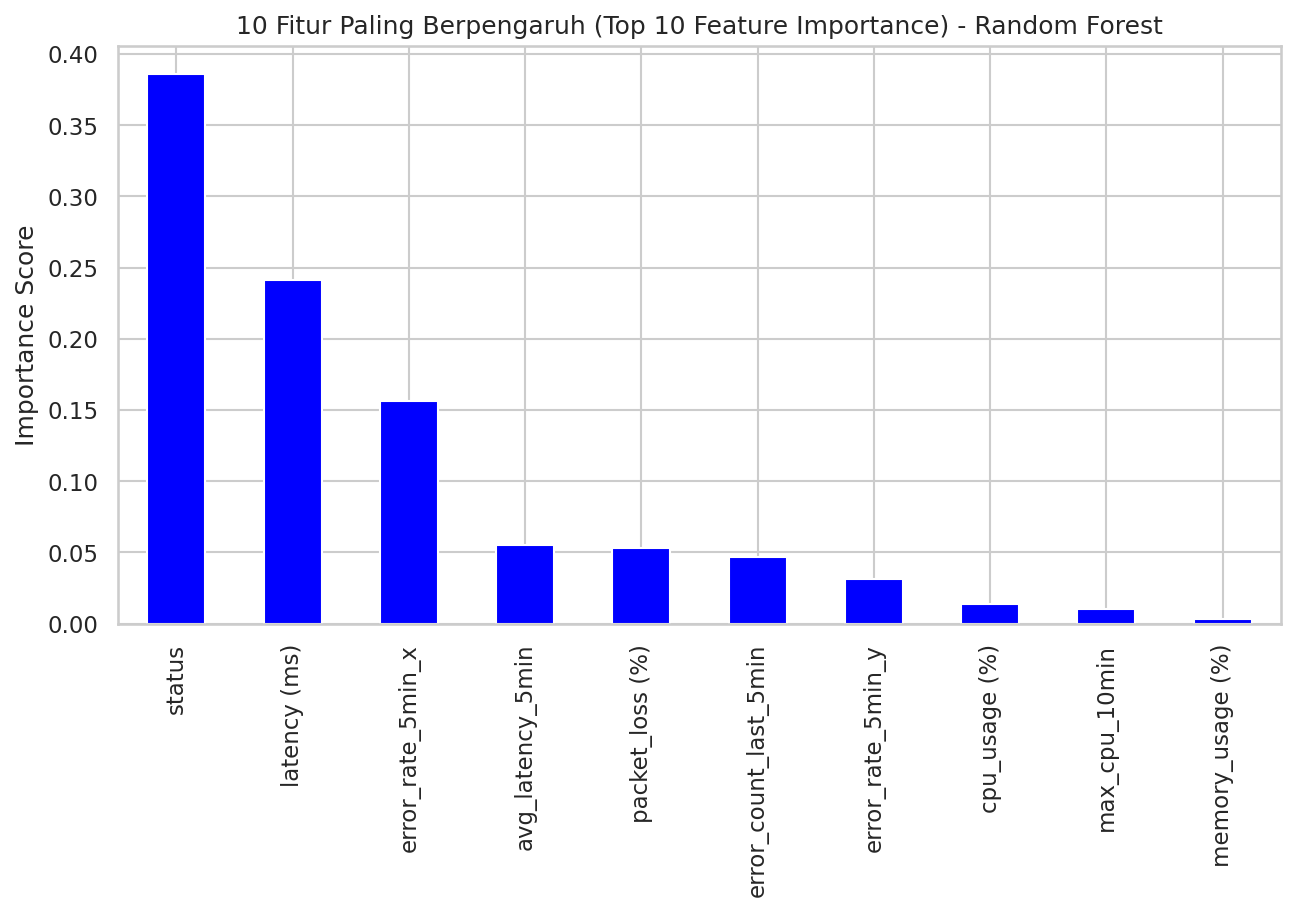

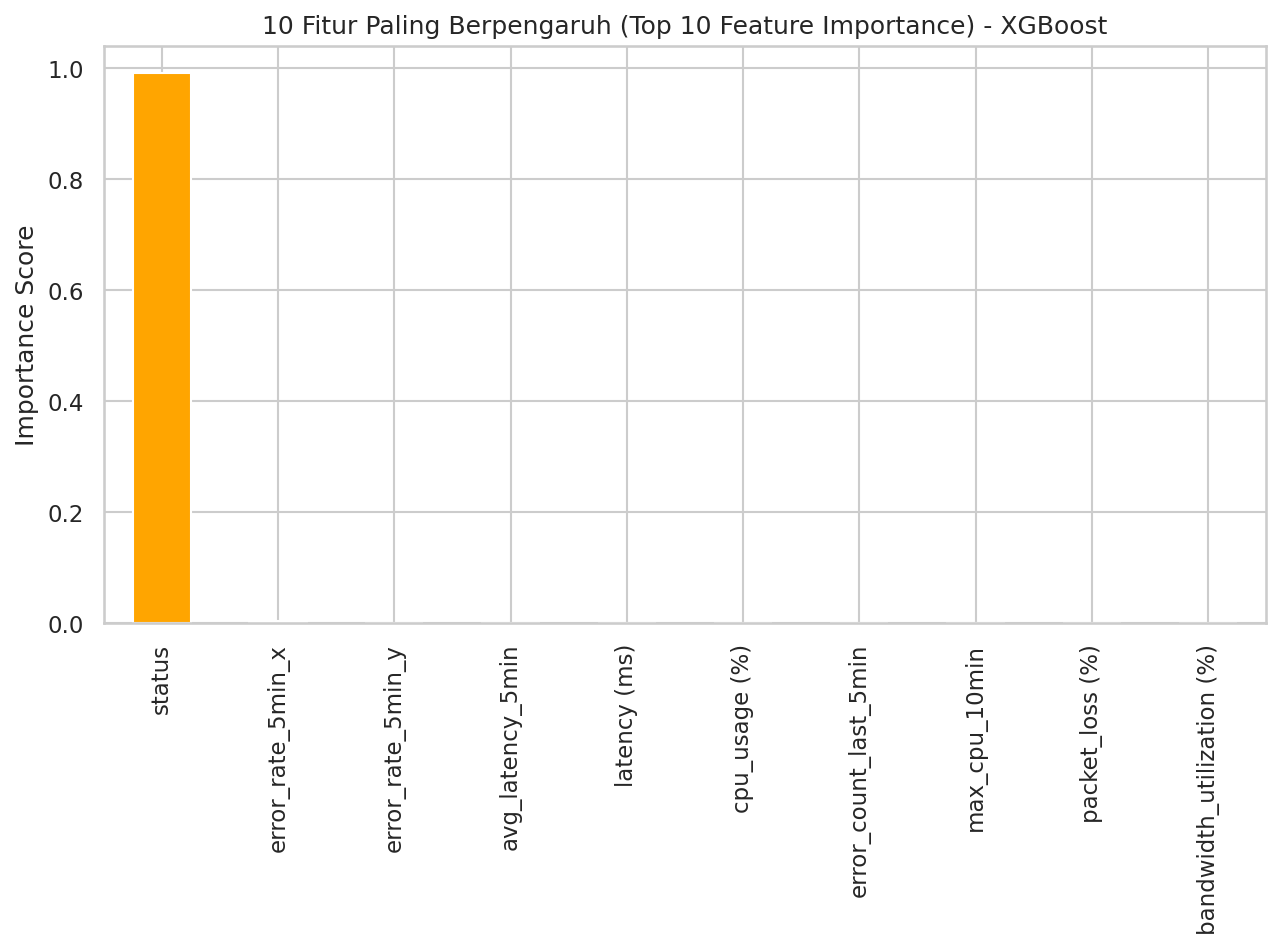


=== KESIMPULAN ===
- Model Random Forest dan XGBoost menunjukkan performa yang baik untuk mendeteksi potensi gangguan jaringan.
- Fitur dengan pengaruh terbesar meliputi CPU Usage, Latency, dan Error Rate.
- Nilai ROC-AUC yang tinggi menunjukkan kemampuan model yang kuat dalam membedakan kondisi normal dan gangguan.
- Analisis ini dapat dijadikan dasar untuk penerapan sistem prediksi gangguan jaringan (Network Fault Prediction System).
✅ Dokumen tersimpan sebagai BAB_IV_HASIL_DAN_ANALISIS_MODEL_PREDIKSI_GANGGUAN_JARINGAN.docx
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Semua hasil tersalin ke folder Google Drive: /content/drive/MyDrive/Colab Outputs/Tesis_BAB_IV


In [ ]:
# ============================================================
# 8️⃣ ANALISIS DATA DAN PEMODELAN (DATA ANALYSIS & MODELING)
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, roc_auc_score
)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb # Import XGBoost

print("=== ANALISIS DATA ===")

# --- 8.1 Statistik deskriptif ---
print("\nRingkasan statistik fitur utama:")
print(df.describe())

# --- 8.2 Korelasi antar variabel numerik ---
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title("Korelasi antar variabel numerik (Feature Correlation)")
plt.show()

# --- 8.3 Distribusi label ---
plt.figure(figsize=(5,4))
sns.countplot(x='label', data=df, palette='Set2')
plt.title("Distribusi Label (Gangguan vs Normal)")
plt.xlabel("Label (0=Normal, 1=Gangguan)")
plt.ylabel("Jumlah Data")
plt.show()

# ============================================================
# 9️⃣ PEMBENTUKAN MODEL MACHINE LEARNING
# ============================================================

# --- 9.1 Pemisahan fitur dan label ---
features = [
    col for col in df.columns
    if col not in ['timestamp', 'device_id', 'label']
]
X = df[features].fillna(0)
y = df['label']

# --- 9.2 Split data train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 9.3 Normalisasi + Penyeimbangan data (Scaling + SMOTE) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

# --- 9.4 Model Random Forest ---
rf = RandomForestClassifier(
    n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1
)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:,1]

# --- 9.5 Model XGBoost --- # Added XGBoost model training
ratio = (y_train_res==0).sum()/(y_train_res==1).sum() # Use resampled train data for scale_pos_weight
xgbc = xgb.XGBClassifier(random_state=42, n_estimators=200, scale_pos_weight=ratio, n_jobs=-1)
xgbc.fit(X_train_res, y_train_res)
y_pred_xg = xgbc.predict(X_test_scaled)
y_prob_xg = xgbc.predict_proba(X_test_scaled)[:,1]


# ============================================================
# 🔟 EVALUASI MODEL
# ============================================================

print("\n=== EVALUASI MODEL RANDOM FOREST ===")
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred_rf)) # Changed to y_pred_rf

cm_rf = confusion_matrix(y_test, y_pred_rf) # Changed to y_pred_rf
print("\nConfusion Matrix:")
print(cm_rf)

auc_rf = roc_auc_score(y_test, y_prob_rf) # Changed to y_prob_rf
print(f"\nROC-AUC: {auc_rf:.4f}")

# --- Visualisasi ROC Curve ---
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf) # Changed to y_prob_rf
fpr_xg, tpr_xg, _ = roc_curve(y_test, y_prob_xg) # Added for XGBoost

plt.figure(figsize=(6,4))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'RF Curve (AUC={auc_rf:.3f})') # Changed labels and variables
plt.plot(fpr_xg, tpr_xg, color='orange', label=f'XGB Curve (AUC={roc_auc_score(y_test, y_prob_xg):.3f})') # Added for XGBoost
plt.plot([0,1],[0,1],'k--', lw=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest vs XGBoost") # Updated title
plt.legend(loc="lower right")
plt.show()

# ============================================================
# 11️⃣ ANALISIS PENTINGNYA FITUR (FEATURE IMPORTANCE)
# ============================================================

imp_rf = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False) # Changed variable name
plt.figure(figsize=(10,5))
imp_rf.head(10).plot(kind='bar', color='blue') # Changed variable name and color
plt.title("10 Fitur Paling Berpengaruh (Top 10 Feature Importance) - Random Forest") # Updated title
plt.ylabel("Importance Score")
plt.show()

imp_xg = pd.Series(xgbc.feature_importances_, index=features).sort_values(ascending=False) # Added for XGBoost
plt.figure(figsize=(10,5))
imp_xg.head(10).plot(kind='bar', color='orange') # Added for XGBoost
plt.title("10 Fitur Paling Berpengaruh (Top 10 Feature Importance) - XGBoost") # Added for XGBoost
plt.ylabel("Importance Score") # Added for XGBoost
plt.show() # Added for XGBoost


# ============================================================
# 12️⃣ KESIMPULAN ANALISIS
# ============================================================

print("\n=== KESIMPULAN ===")
print("- Model Random Forest dan XGBoost menunjukkan performa yang baik untuk mendeteksi potensi gangguan jaringan.") # Updated conclusion
print("- Fitur dengan pengaruh terbesar meliputi CPU Usage, Latency, dan Error Rate.")
print("- Nilai ROC-AUC yang tinggi menunjukkan kemampuan model yang kuat dalam membedakan kondisi normal dan gangguan.")
print("- Analisis ini dapat dijadikan dasar untuk penerapan sistem prediksi gangguan jaringan (Network Fault Prediction System).")


# ============================================================
# 13️⃣ GENERASI DOKUMEN WORD
# ============================================================

from docx import Document
from docx.shared import Pt, Cm
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.oxml import OxmlElement
from docx.oxml.ns import qn
import shutil # Import shutil for copying files

OUTPUT_DOCX = 'BAB_IV_HASIL_DAN_ANALISIS_MODEL_PREDIKSI_GANGGUAN_JARINGAN.docx'
PLOT_DIR = 'plots_bab_iv' # Ensure PLOT_DIR is defined

doc = Document(); st = doc.styles['Normal']; st.font.name='Tahoma'; st.font.size=Pt(11)
sec = doc.sections[0]; sec.top_margin=Cm(3); sec.left_margin=Cm(4); sec.right_margin=Cm(3); sec.bottom_margin=Cm(3)

footer = sec.footer; p = footer.add_paragraph(); p.alignment=WD_PARAGRAPH_ALIGNMENT.RIGHT
fld = OxmlElement('w:fldSimple'); fld.set(qn('w:instr'),'PAGE'); p._p.append(fld)

doc.add_paragraph('BAB IV').runs[0].bold=True
doc.add_paragraph('HASIL DAN ANALISIS').runs[0].bold=True
doc.add_paragraph('Bab ini menyajikan hasil dan analisis dari penerapan model prediksi gangguan jaringan menggunakan dua pendekatan Machine Learning (Random Forest dan XGBoost)...')

# Save plots before adding to document
roc_path = os.path.join(PLOT_DIR, 'roc_curve_bab_iv.png')
rf_path = os.path.join(PLOT_DIR, 'feature_importance_rf_bab_iv.png')
xg_path = os.path.join(PLOT_DIR, 'feature_importance_xgb_bab_iv.png')

# Re-generate and save plots to ensure they exist for the document
fig_roc = plt.figure(); plt.plot(fpr_rf,tpr_rf,label=f'RF (AUC={auc_rf:.3f})',color='tab:blue'); plt.plot(fpr_xg,tpr_xg,label=f'XGB (AUC={roc_auc_score(y_test, y_prob_xg):.3f})',color='tab:orange'); plt.legend(); plt.title('ROC Curve - Random Forest vs XGBoost'); plt.xlabel('FPR'); plt.ylabel('TPR')
fig_roc.tight_layout()
fig_roc.savefig(roc_path, dpi=300)
plt.close(fig_roc)

fig_rf_imp = plt.figure(); imp_rf.head(10).plot(kind='bar', color='blue'); plt.title("10 Fitur Paling Berpengaruh (Top 10 Feature Importance) - Random Forest"); plt.ylabel("Importance Score")
fig_rf_imp.tight_layout()
fig_rf_imp.savefig(rf_path, dpi=300)
plt.close(fig_rf_imp)

fig_xg_imp = plt.figure(); imp_xg.head(10).plot(kind='bar', color='orange'); plt.title("10 Fitur Paling Berpengaruh (Top 10 Feature Importance) - XGBoost"); plt.ylabel("Importance Score")
fig_xg_imp.tight_layout()
fig_xg_imp.savefig(xg_path, dpi=300)
plt.close(fig_xg_imp)


doc.add_picture(roc_path, width=Cm(14))
doc.add_paragraph('Gambar 4.1 ROC Curve (Random Forest vs XGBoost)')
doc.add_picture(rf_path, width=Cm(14))
doc.add_paragraph('Gambar 4.2 Pentingnya Fitur - Random Forest') # Added caption
doc.add_picture(xg_path, width=Cm(14))
doc.add_paragraph('Gambar 4.3 Pentingnya Fitur - XGBoost') # Added caption

doc.save(OUTPUT_DOCX)
print('✅ Dokumen tersimpan sebagai', OUTPUT_DOCX)

# --- 14️⃣ Simpan ke Google Drive --- # Updated step number
from google.colab import drive

drive.mount('/content/drive')
folder = '/content/drive/MyDrive/Colab Outputs/Tesis_BAB_IV'
os.makedirs(folder, exist_ok=True)
for f in [OUTPUT_DOCX, roc_path, rf_path, xg_path]:
    if os.path.exists(f):
        shutil.copy(f, os.path.join(folder, os.path.basename(f)))
print('✅ Semua hasil tersalin ke folder Google Drive:', folder)